INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files


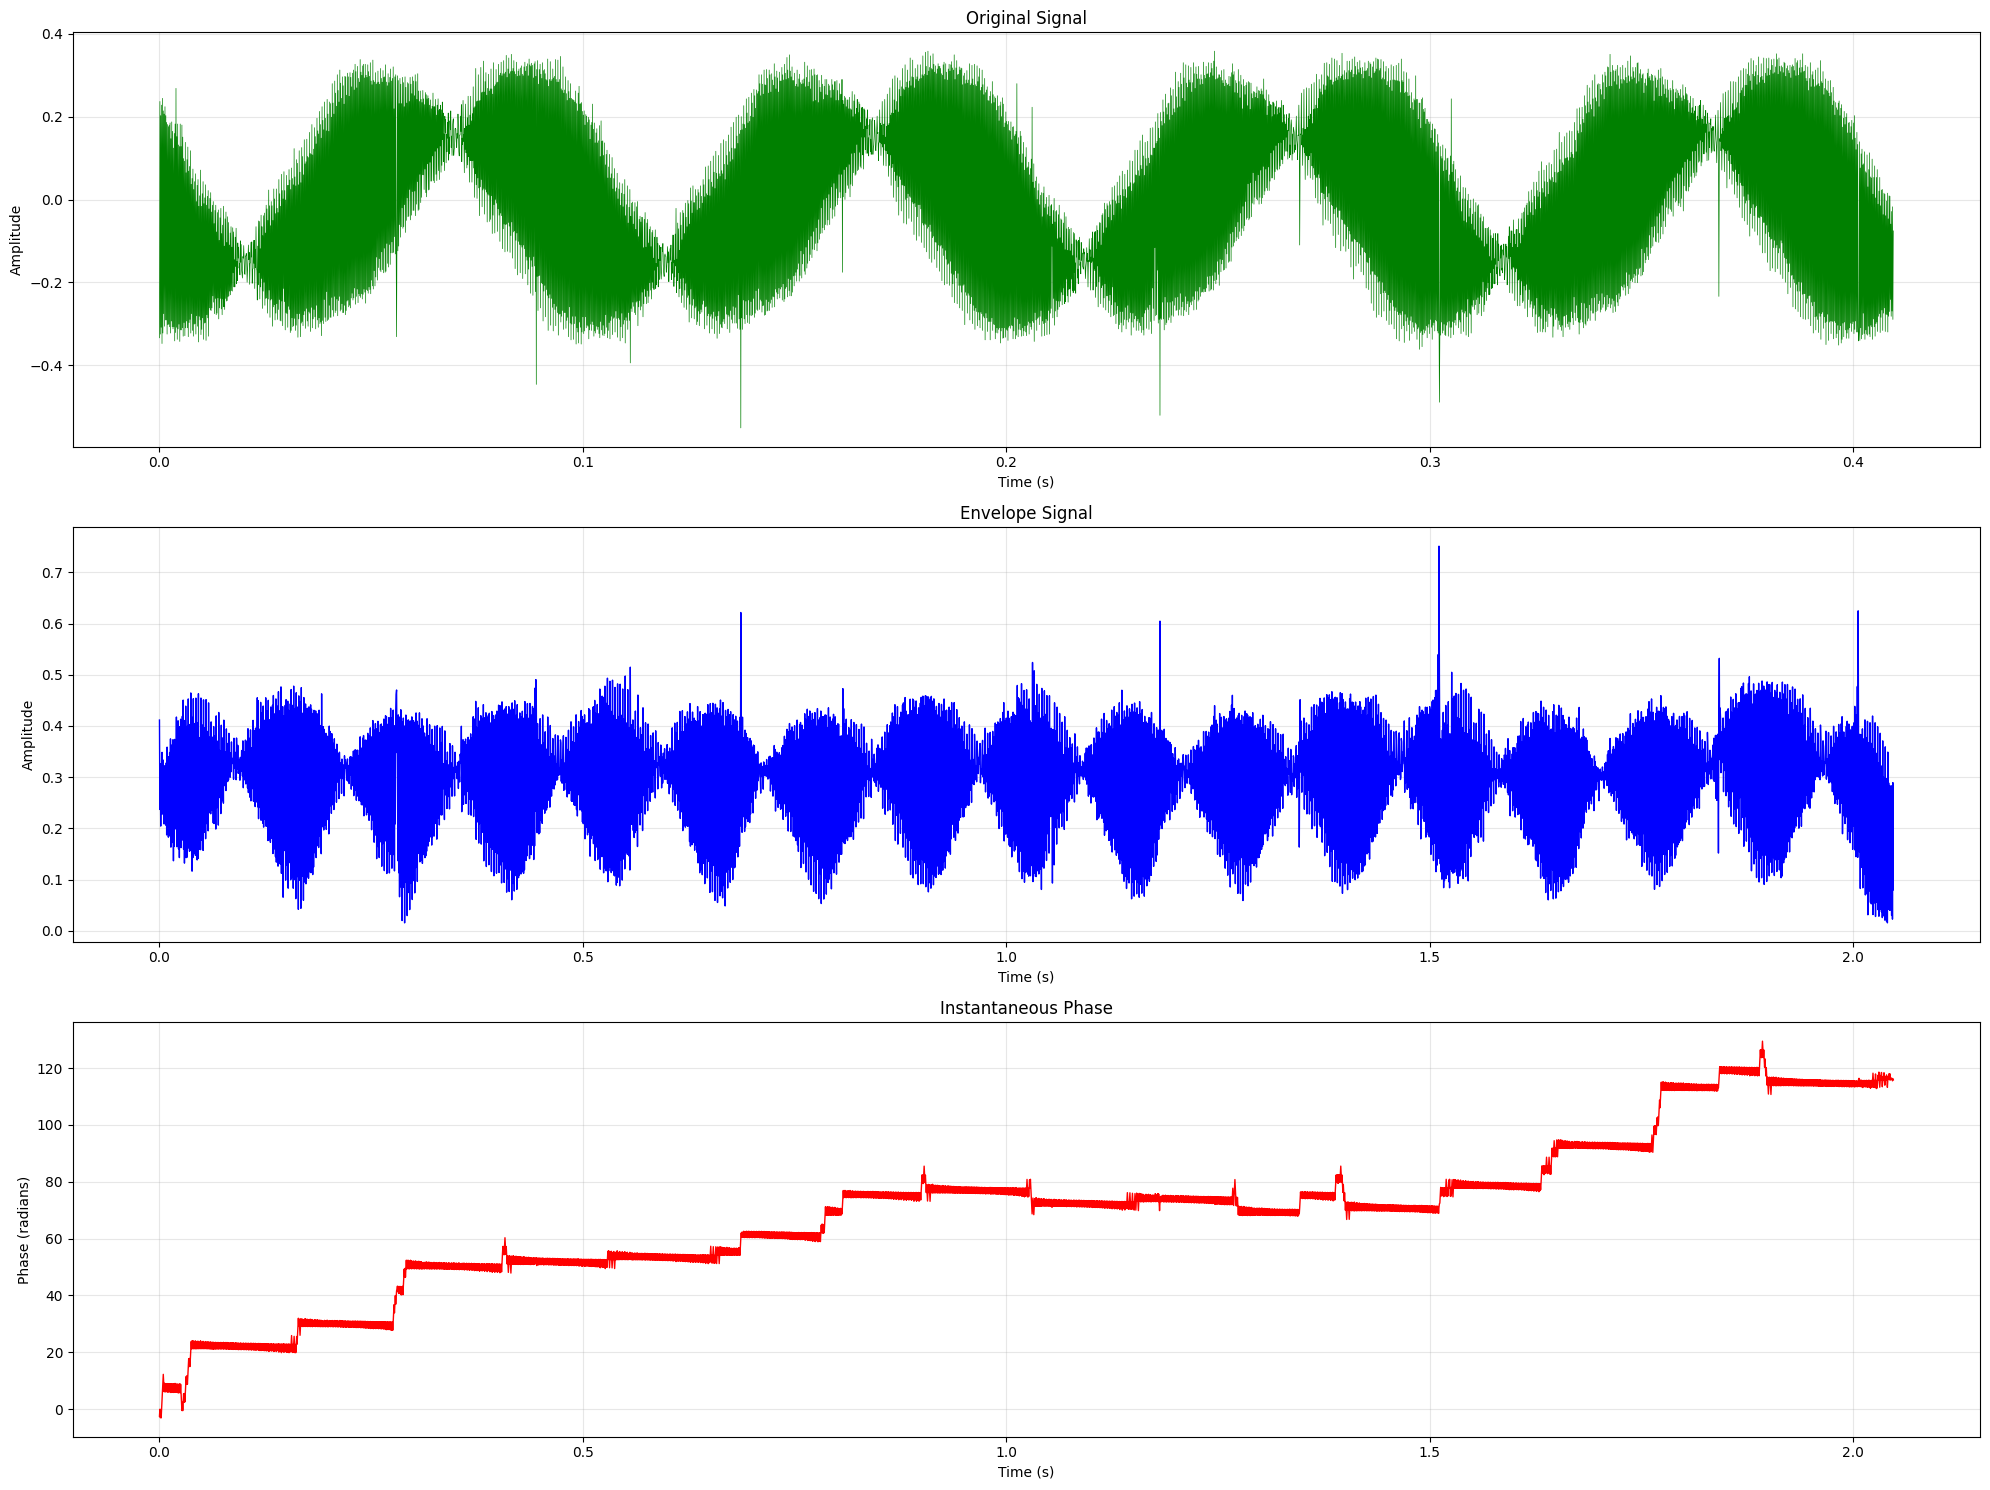

Original sampling frequency: 10000 Hz
Envelope sampling frequency: 2000.0 Hz
Signal duration: 2.05 seconds
Original signal range: -0.5507 to 0.3578
Envelope amplitude range: 0.0155 to 0.7511
Phase range: -3.10 to 129.49 radians


In [ ]:
import sys
import pandas as pd
from pathlib import Path
project_root = Path("..").resolve()
sys.path.append(str(project_root))
from ml_toolbox import HilbertEnvelopeAnalyzer, EnvelopeConfig, DataLoader, WindowConfig, WindowExtractor


# Load data and create windows
dataset_path = Path("../data_set")
data_loader = DataLoader(dataset_path)

frequency = '20hz'
sensor_type = 'current'
load = 'no_load'
sampling_rate = 10000

healthy, healthy_metadata = data_loader.load_batch(
    condition='system_misalignment', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)

n_healthy = 4096#healthy[0].shape[0]

# Create windows
overlap_ratio = 0.5
healthy_step_size = int(n_healthy * (1 - overlap_ratio))
healthy_window_config = WindowConfig(window_size=n_healthy, 
                             step_size=healthy_step_size,
                             overlap_ratio=overlap_ratio)
healthy_extractor = WindowExtractor(healthy_window_config)
healthy_windows, healthy_win_metadata = healthy_extractor.extract_windows(healthy[0], healthy_metadata[0])

h_w = healthy_windows[0]
h_ch1 = h_w[:, 0]
h_ch2 = h_w[:, 1]

# carrier freqs: 1670, 3330
carrier_freq = 3330
env_conf = EnvelopeConfig(
    bandpass_low=carrier_freq - 50,
    bandpass_high=carrier_freq + 50,
    lowpass_cutoff=200.0,
    filter_order=4,
    decimation_factor=5,
    sampling_rate=10000 # current fs
)

analyzer = HilbertEnvelopeAnalyzer(env_conf)

stages = analyzer.extract_envelope_with_stages(h_ch1, return_stages=True)

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 1, figsize=(20, 15))

orig = stages['original']
from scipy.signal import hilbert
env = stages['envelope_decimated']
inst_phase = np.unwrap(np.angle(env))

ts_orig = env_conf.sampling_rate
ts_env = env_conf.envelope_fs
t_orig = np.arange(len(orig)) / ts_orig
t_env = np.arange(len(env)) / ts_env

# Plot original signal
axs[0].plot(t_orig, orig, 'g-', linewidth=0.5)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Original Signal')
axs[0].grid(True, alpha=0.3)

# Plot envelope
axs[1].plot(t_env, env, 'b-', linewidth=1)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Envelope Signal')
axs[1].grid(True, alpha=0.3)

# Plot instantaneous phase
axs[2].plot(t_env, inst_phase, 'r-', linewidth=1)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Phase (radians)')
axs[2].set_title('Instantaneous Phase')
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some basic info
print(f"Original sampling frequency: {ts_orig} Hz")
print(f"Envelope sampling frequency: {ts_env} Hz")
print(f"Signal duration: {len(env)/ts_env:.2f} seconds")
print(f"Original signal range: {np.min(orig):.4f} to {np.max(orig):.4f}")
print(f"Envelope amplitude range: {np.min(np.abs(env)):.4f} to {np.max(np.abs(env)):.4f}")
print(f"Phase range: {np.min(inst_phase):.2f} to {np.max(inst_phase):.2f} radians")